# Example of sampling parameters

## Model description

Impulse response models and parameter sampling
based on Tsutsui (2022, https://doi.org/10.5194/gmd-15-951-2022)

The MCE model is essentially built on impulse response functions for the fraction of the total CO<sub>2</sub> emitted that remains in the atmosphere (termed the airborne fraction), the decay of land carbon accumulated by the CO<sub>2</sub> fertilization effect, and temperature change to radiative forcing of CO<sub>2</sub> and other forcing agents. Under the linear response assumption with regard to input forcing $F$, an impulse response model (IRM) expresses the time change of a response variable $x$ by a convolution integral:
$$
x(t) = \int_{0}^{t} F(t^{'}) \sum_{i} A_{i}
\exp\left( -\frac{t-t'}{\tau_{i}}\right) dt^{'},
$$
where $t$ is time, and the sum of exponentials is an impulse response function with parameters $A_i$ and $\tau_i$ denoting the $i$-th component of the response amplitude and time constant, respectively. The time derivative of this equation is given by:
$$
\frac{dx(t)}{dt} = \sum_{i}
\left[ F(t) A_{i} - \frac{x_{i}(t)}{\tau_{i}} \right],
$$
or an equivalent box model form that is converted into the original IRM through Laplace transform or eigenfunction expansion. The time derivative implemented in the MCE uses an IRM form for land carbon decay and temperature change, and a box model form for the airborne fraction, to address partitioning of excess carbon between the atmosphere and ocean mixed layer.

There are a number of uncertain parameters, not only for the IRM amplitudes and time constants, but also for several control parameters used in forcing terms. To deal with these uncertainties, probabilistic runs are conducted with an ensemble of perturbed model parameters designed to encompass the variation of multiple CMIP models with additional constraints with regard to key indicators.

In general, a series of candidate values of an uncertain parameter is generated from its statistical model and, if necessary, sampled from the series with an acceptance algorithm for given constraints. The latter process is Bayesian updating from a prior probability distribution to a posterior and here uses a Metropolis-Hastings (MH) independence sampler.

In [ ]:
%cd ..

In [2]:
from io import StringIO
import yaml
import textwrap
import numpy as np
import pandas as pd
import matplotlib as mpl
import scipy.stats
from tqdm.notebook import tqdm
from mce import MCECalibError
from mce.core import ScenarioBase
from mce.core.driver import DriverBase
from mce.core.genparms import PcaParmsCmip
from mce.util.stat import StatModel, SamplingMH
from mce.util.plot_base import PlotBase

In [3]:
# Parameter attributes: long_name and units
with open('mce/core/attributes.yml') as f1:
    attrs = yaml.safe_load(f1)

In [4]:
class DocParms:
    def __init__(self, attrs):
        """Manipulation of parameter attributes

        Parameters
        ----------
        attrs
            Definition of parameter attributes
        """
        self.attrs = attrs

    def _mkdesc(self, cat, name, att):
        return '{}|{}: {} ({})'.format(
            cat, name, att['long_name'], att['units'],
        )
        
    def desc(self, *args, **kw):
        cats = kw.get('cats', list(self.attrs))
        if isinstance(cats, str):
            cats = [cats]

        for name in args:
            cats_found = []

            for cat, atts_cat in self.attrs.items():
                if cat not in cats:
                    continue

                if name in atts_cat:
                    cats_found.append(cat)

            if len(cats_found) > 0:
                for cat in cats_found:
                    print(self._mkdesc(cat, name, self.attrs[cat][name]))
            else:
                print(f'{name} not defined')

    def __call__(self, *args, **kw):
        self.desc(*args, **kw)

doc_parms = DocParms(attrs['parameters'])

In [5]:
# Plotting module
myplt = PlotBase(palette='ipcc_wg1')

In [6]:
# Sampling size
nsize = 2000

# Fixed random seed setting for reproduction
seed_climate = 1
seed_ocean = 11
seed_land = 21

## 1. Sampling

### 1.1 Climate and CO2 forcing parameters

The temperature response parameters are synthetically generated with CO<sub>2</sub> forcing parameters from a multivariate normal distribution, built on principal components (PCs) of diagnosed parameters for each of the CMIP models.

In the standard configuration, the IRM of the temperature change defines three components with typical time constants of approximately 1, 10, and > 100 years. The response amplitude is rewritten by $\tilde{A}_i/(\lambda \tau_i)$, where $\tilde{A}_i$ is normalized so that the component sum is unity, and $\lambda$ is the climate feedback parameter in W/m<sup>2</sup>/degC, defined as the derivative of the outgoing thermal flux with respect to temperature change.

CO<sub>2</sub> forcing is evaluated with the following quadratic formula, in terms of the logarithm of CO<sub>2</sub> concentration:
$$
F_{\mathrm{C}}(x) = (\beta_{\mathrm{C}} - 1)
[\hat{F}_{\mathrm{C}}(x) - 2F_{\mathrm{C}}(2)]
[2\hat{F}_{\mathrm{C}}(x)/F_{\mathrm{C}}(2) - 1]
+ \beta_{\mathrm{C}} \hat{F}_{\mathrm{C}}(x)
$$
$$
\hat{F}_{\mathrm{C}}(x) = \alpha_{\mathrm{C}}
\ln [\mathrm{CO_{2}(t)/\mathrm{CO_{2}(0)}}],
$$
where $x$ is the ratio of CO<sub>2</sub> concentrations to a preindustrial level, $\alpha_{\mathrm{C}}$ is a scaling parameter in W/m<sup>2</sup>, and $\beta_{\mathrm{C}}$ is an amplification factor defined as $F_{\mathrm{C}}(4) = \beta_{\mathrm{C}} \times \hat{F}_{\mathrm{C}}(4)$.

The quadratic term is activated when the concentration exceeds a two-times level ($x>2$), and $\beta_{\mathrm{C}}$ is set to unity in the range $x \le 2$ so that $F_{\mathrm{C}}$ is equivalent to $\hat{F}_{\mathrm{C}}$. The forcing amplification is expected to be valid in the range $x \le 4$ and the quadratic term is dropped beyond a four-time level.

In [7]:
outpath = 'data/calib_cmip.h5'
ds_calib = ScenarioBase(outpath=outpath)

[2025-04-30 15:32:30 mce.core] INFO:data/calib_cmip.h5 already exists
[2025-04-30 15:32:30 mce.core] INFO:file data/calib_cmip.h5 opened with mode=r


In [8]:
def kw2dict(kw_all):
    """Return model parameters as dict
    """
    return {
        'co2_alpha': kw_all['kw_rfall']['alpha'],
        'co2_beta': kw_all['kw_rfall']['beta'],
        'lambda': kw_all['kw_irm']['lamb'],
        **dict(zip([f'a{j}' for j in range(3)], kw_all['kw_irm']['asj'])),
        **dict(zip([f'tau{j}' for j in range(3)], kw_all['kw_irm']['tauj'])),
    }

In [9]:
calib_type = 'l3_norm1' # 3-layer IRM with CMIP normalization type 1

index = []
parms = []

for cmip_era, g1 in ds_calib.file['parms'].items():
    for model, g2 in g1.items():
        index.append((cmip_era, model))
        parms.append(kw2dict({
            comp: dict(g3.attrs.items())
            for comp, g3 in g2[calib_type].items()
        }))

In [10]:
ds_calib.close()

[2025-04-30 15:32:30 mce.core] INFO:file data/calib_cmip.h5 closed


In [11]:
df = (
    pd.DataFrame(parms, pd.MultiIndex.from_tuples(index))
    .sort_index(key=lambda x: x.str.lower())
)
df

co2_alpha  co2_beta    lambda        a0        a1  \
CMIP5 ACCESS1.0     4.246654  1.019410  0.784776  0.309701  0.186391   
      ACCESS1.3     3.925020  1.075596  0.834143  0.183191  0.311308   
      BCC-CSM1.1    4.450616  1.037867  1.130385  0.349640  0.278756   
      BNU-ESM       5.453729  1.007902  0.970155  0.288967  0.349246   
      CanESM2       5.352105  1.018086  1.018415  0.447794  0.222856   
...                      ...       ...       ...       ...       ...   
CMIP6 NorESM2-LM    4.070018  1.178751  1.285577  0.071654  0.519140   
      NorESM2-MM    4.296143  1.211978  1.428425  0.146186  0.483434   
      SAM0-UNICON   5.252838  1.006970  0.958214  0.079876  0.471748   
      TaiESM1       5.293819  1.002893  0.824424  0.194131  0.350745   
      UKESM1-0-LL   5.222636  1.006065  0.681346  0.264903  0.308512   

                         a2      tau0       tau1        tau2  
CMIP5 ACCESS1.0    0.503909  1.771025  11.862830  219.728920  
      ACCESS1.3    0.505501  1.084692   7.637977  255.383861  
      BCC-CSM1.1   0.371604  1.677255   9.770735  141.682897  
      BNU-ESM      0.361787  1.255106   9.066619  291.727753  
      CanESM2      0.329350  2.171617  21.438134  261.580547  
...                     ...       ...        ...         ...  
CMIP6 NorESM2-LM   0.409207  0.009143   1.822130  228.450360  
      NorESM2-MM   0.370380  0.065719   2.321406  217.502799  
      SAM0-UNICON  0.448376  0.349683   3.997234  265.292200  
      TaiESM1      0.455124  0.829860   8.347437  262.912735  
      UKESM1-0-LL  0.426585  1.466066  18.557701  317.950803  

[68 rows x 9 columns]

In [12]:
def add_ecs_tcr(df, inplace=True):
    """Add analytically derived ECS and TCR

    Parameters
    ----------
    df
        Parameter DataFrame
    """
    q2x = df['co2_alpha'] * np.log(2)
    ecs = q2x / df['lambda']

    asj = df[['a0', 'a1', 'a2']].rename(columns=lambda x: x.replace('a', ''))
    tauj = df[['tau0', 'tau1', 'tau2']].rename(columns=lambda x: x.replace('tau', ''))
    t70 = np.log(2) / np.log(1.01)
    rwf = 1. - (asj * tauj * (1 - np.exp(-t70/tauj))).sum(axis=1) / t70

    tcr = ecs * rwf

    if inplace:
        df['ecs'] = ecs
        df['tcr'] = tcr
    else:
        return pd.DataFrame({'ecs': ecs, 'tcr': tcr})

In [13]:
add_ecs_tcr(df, inplace=True)

In [14]:
df_parms_cmip = df
df_parms_cmip

co2_alpha  co2_beta    lambda        a0        a1  \
CMIP5 ACCESS1.0     4.246654  1.019410  0.784776  0.309701  0.186391   
      ACCESS1.3     3.925020  1.075596  0.834143  0.183191  0.311308   
      BCC-CSM1.1    4.450616  1.037867  1.130385  0.349640  0.278756   
      BNU-ESM       5.453729  1.007902  0.970155  0.288967  0.349246   
      CanESM2       5.352105  1.018086  1.018415  0.447794  0.222856   
...                      ...       ...       ...       ...       ...   
CMIP6 NorESM2-LM    4.070018  1.178751  1.285577  0.071654  0.519140   
      NorESM2-MM    4.296143  1.211978  1.428425  0.146186  0.483434   
      SAM0-UNICON   5.252838  1.006970  0.958214  0.079876  0.471748   
      TaiESM1       5.293819  1.002893  0.824424  0.194131  0.350745   
      UKESM1-0-LL   5.222636  1.006065  0.681346  0.264903  0.308512   

                         a2      tau0       tau1        tau2       ecs  \
CMIP5 ACCESS1.0    0.503909  1.771025  11.862830  219.728920  3.750823   
      ACCESS1.3    0.505501  1.084692   7.637977  255.383861  3.261569   
      BCC-CSM1.1   0.371604  1.677255   9.770735  141.682897  2.729099   
      BNU-ESM      0.361787  1.255106   9.066619  291.727753  3.896530   
      CanESM2      0.329350  2.171617  21.438134  261.580547  3.642716   
...                     ...       ...        ...         ...       ...   
CMIP6 NorESM2-LM   0.409207  0.009143   1.822130  228.450360  2.194439   
      NorESM2-MM   0.370380  0.065719   2.321406  217.502799  2.084715   
      SAM0-UNICON  0.448376  0.349683   3.997234  265.292200  3.799767   
      TaiESM1      0.455124  0.829860   8.347437  262.912735  4.450862   
      UKESM1-0-LL  0.426585  1.466066  18.557701  317.950803  5.313093   

                        tcr  
CMIP5 ACCESS1.0    1.982799  
      ACCESS1.3    1.697960  
      BCC-CSM1.1   1.798378  
      BNU-ESM      2.445166  
      CanESM2      2.298460  
...                     ...  
CMIP6 NorESM2-LM   1.390633  
      NorESM2-MM   1.390147  
      SAM0-UNICON  2.196986  
      TaiESM1      2.474002  
      UKESM1-0-LL  2.821650  

[68 rows x 11 columns]

In [15]:
doc_parms(
    *sorted(df_parms_cmip),
    **{'cats': ['forcing', 'climate']},
)

climate|a0: Fraction of the first time constant contribution to the surface temperature change (no_unit)
climate|a1: Fraction of the second time constant contribution to the surface temperature change (no_unit)
climate|a2: Fraction of the third time constant contribution to the surface temperature change (no_unit)
forcing|co2_alpha: Scaling factor of CO2 forcing (W m-2)
forcing|co2_beta: Amplification factor of CO2 forcing (no_unit)
climate|ecs: Equilibrium climate sensitivity (K)
climate|lambda: Climate feedback parameter (W m-2 K-1)
climate|tau0: First (shortest) time constant (yr)
climate|tau1: Second time constant (yr)
climate|tau2: Third time constant (yr)
climate|tcr: Transient climate response (K)


In [16]:
# Eight independent parameters to be fed into PC analysis

# Selected parameters:
names0 = [
    'tcr', 'co2_alpha', 'co2_beta', 'tau0', 'tau1', 'tau2', 'a0', 'a1', 'a2',
]

# Used parameters:
names = [
    'tcr', 'co2_alpha', 'co2_beta', 'tau0', 'tau1', 'tau2', 'af0', 'af2',
]
# including two derived parameters: af0 and af2, defined as a0/a1 and a2/a1

# Those for which logarithmic transformation is applied for normality
# and ensuring positive values
names_log = [
    'co2_beta', 'tcr', 'tau0', 'tau1', 'tau2', 'af0', 'af2',
]

In [17]:
# Check outliers, here defined as exceeding three times the standard deviation
# of the ensemble for any of the selected parameters
outlier = (
    df_parms_cmip[names0]
    .apply(lambda x: np.abs(scipy.stats.zscore(x)) > 3)
    .any(axis=1)
)
df_parms_cmip[outlier]

,,co2_alpha,co2_beta,lambda,a0,a1,a2,tau0,tau1,tau2,ecs,tcr
CMIP5,GFDL-CM3,4.206727,1.027046,0.751565,0.375365,0.261416,0.363219,2.763182,45.018009,396.691220,3.879747,2.013614
CMIP6,ACCESS-CM2,4.358091,1.125282,0.721581,0.322765,0.383461,0.293774,2.164679,37.503339,3655.419818,4.186361,2.196805


In [18]:
# Perform PC analysis
pc = PcaParmsCmip(names, names_log=names_log)
score = pc.analysis(df_parms_cmip.loc[np.logical_not(outlier)])

[2025-04-30 15:32:30 mce.core.genparms] INFO:ev0 reversed
[2025-04-30 15:32:30 mce.core.genparms] INFO:ev0 reversed
[2025-04-30 15:32:30 mce.core.genparms] INFO:ev1 reversed
[2025-04-30 15:32:30 mce.core.genparms] INFO:ev1 reversed
[2025-04-30 15:32:30 mce.core.genparms] INFO:ev2 reversed
[2025-04-30 15:32:30 mce.core.genparms] INFO:ev2 reversed
[2025-04-30 15:32:30 mce.core.genparms] INFO:ev5 reversed
[2025-04-30 15:32:30 mce.core.genparms] INFO:ev5 reversed


In [19]:
# Sampling based on a multivariate normal distribution
df_parms_p_climate, score_p = pc.genparms(
    pc.eigval, nsize=nsize, seed=seed_climate,
)
df_parms_p_climate

,tcr,co2_alpha,co2_beta,tau0,tau1,tau2,a1,a2,a0,ecs,lambda,ecs_reg
0,2.086637,4.797613,1.010333,19.423003,17.610348,321.864974,0.322195,0.269245,0.408560,3.678544,0.904013,3.716554
1,1.995382,4.714902,1.084927,1.058298,9.446341,728.164267,0.362858,0.390712,0.246430,3.473393,0.940902,3.768380
2,1.933390,5.490324,1.004539,0.340694,5.378029,242.696679,0.337546,0.451780,0.210674,3.332370,1.142011,3.347496
3,1.904409,5.362270,1.047308,1.070986,12.308659,336.980427,0.275920,0.303781,0.420298,2.840214,1.308648,2.974579
4,1.569668,5.147370,1.001675,0.529614,3.968672,235.983628,0.382323,0.422756,0.194921,2.570421,1.388055,2.574727
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.757656,3.940210,1.050601,1.354591,9.387831,265.794687,0.300911,0.400031,0.299058,2.920898,0.935036,3.068698
1996,2.001983,3.920556,1.193187,0.949790,9.094950,323.846513,0.234724,0.569180,0.196096,4.404142,0.617038,5.254966
1997,2.082221,5.071234,1.110926,0.102448,5.810212,186.029219,0.388933,0.447358,0.163709,3.504386,1.003061,3.893112
1998,2.040738,5.314333,1.126993,4.282351,15.776175,289.102452,0.185418,0.336466,0.478116,3.238621,1.137402,3.649904


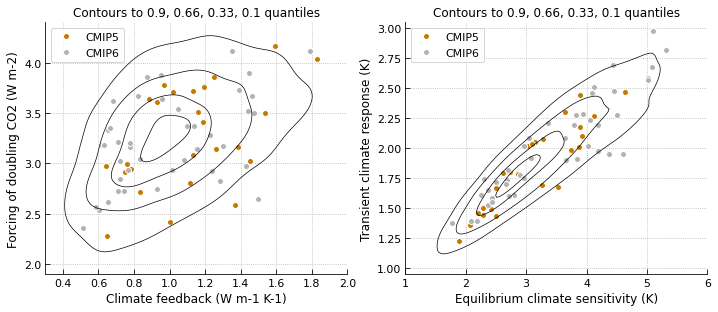

In [20]:
# Characteristic relationships associated with temperature response

df_parms_p = df_parms_p_climate.copy()

df_parms_cmip['erf|2xCO2'] = df_parms_cmip['co2_alpha'] * np.log(2)
df_parms_p['erf|2xCO2'] = df_parms_p['co2_alpha'] * np.log(2)

variables = {
    'lambda': ('Climate feedback', 'W m-1 K-1'),
    # 'ecs_reg': ('Equilibrium climate sensitivity', 'degC'),
    'ecs': ('Equilibrium climate sensitivity', 'K'),
    'tcr': ('Transient climate response', 'K'),
    'erf|2xCO2': ('Forcing of doubling CO2', 'W m-2'),
}

map_lim = {
    # 'ecs_reg': (1., 6.),
    'ecs': (1., 6.),
    'tcr': (0.95, 3.05),
    'lambda': (0.3, 2.),
    'erf|2xCO2': (1.9, 4.4),
}
map_colors = {
    'CMIP5': 'C2',
    'CMIP6': 'C3',
}
kw_plot_cmip = {'ls': 'None', 'marker': 'o', 'mec': 'w'}
prob_ref = np.array([0.90, 0.66, 0.33, 0.1])

myplt.init_regular(2, col=2, kw_space={'height': 3.5, 'aspect': 1.2})

for ax, (xvar, yvar) in zip(
    myplt(),
    # [('lambda', 'erf|2xCO2'), ('ecs_reg', 'tcr')],
    [('lambda', 'erf|2xCO2'), ('ecs', 'tcr')],
):
    for mip, df in df_parms_cmip.groupby(level=0):
        ax.plot(
            df[xvar].values, df[yvar].values, color=map_colors[mip],
            label=mip.upper(), **kw_plot_cmip)

    ax.legend()

    xlim = map_lim[xvar]
    ylim = map_lim[yvar]
    xp, yp = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
    positions = np.vstack([xp.ravel(), yp.ravel()])

    din = df_parms_p.loc[:nsize, [xvar, yvar]].T.values
    pdf = scipy.stats.gaussian_kde(din)
    zp = pdf(positions).reshape(xp.shape)
    levels = np.quantile(pdf(din), 1.-prob_ref)
    ax.contour(xp, yp, zp, levels, colors='C0', linewidths=0.7)

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.grid()
    ax.set_xlabel('{} ({})'.format(*variables[xvar]))
    ax.set_ylabel('{} ({})'.format(*variables[yvar]))
    ax.set_title(
        'Contours to {} quantiles'.format(
            ', '.join([f'{x}' for x in prob_ref])
        )
    )

del df_parms_p

### 1.2 Ocean carbon cycle

The IRM for the airborne fraction defines five components, one of which has infinity time constant, paired with an amplitude corresponding to an asymptotic long-term fraction. In the current configuration, the remaining four time constants are fixed at 236.5, 59.52, 12.17, and 1.271 years, adjusted to a specific three-dimensional ocean carbon cycle model in Hooss et al. (2001, http://dx.doi.org/10.1007/s003820100170). The corresponding amplitudes assume perturbations at reference values of 0.24, 0.21, 0.25, and 0.1, respectively, with a reference long-term airborne fraction of 0.20. These reference values and perturbation ranges are set empirically so that resulting carbon budgets&mdash;cumulative land and ocean CO<sub>2</sub> uptake&mdash;agree with those of historical observations and CMIP experiments.

The perturbations are generated with a uniform distribution for each of the amplitudes, except for the one corresponding to the shortest time constant. Since the sum of the amplitudes is unity, their perturbed values are normalized as such, subject to a modified distribution with more samples about the mean resulting from the operation.

In [21]:
# Dummy driver to use the ocean carbon cycle module
drv = DriverBase()

In [22]:
# Reference amplitudes in terms of the airborne fraction
amp_ref = drv.ocean.parms.amp_ref
amp_ref

array([0.2 , 0.24, 0.21, 0.25, 0.1 ])

In [23]:
# amp parameters are perturbed
# except for amp4 corresponding to the shortest time constant
perturb_ocean = 0.05
amp = amp_ref[None, :] + np.zeros((nsize, len(amp_ref)))
np.random.seed(seed_ocean)
rnd = (np.random.rand(nsize, 4)/0.5 - 1.) * perturb_ocean
amp[:, :4] = amp[:, :4] + rnd
amp[:, :4] *= (amp_ref[:4].sum() / amp[:, :4].sum(axis=1)).reshape((-1, 1))
df_parms_p_ocean_irm = pd.DataFrame(amp).rename(columns=lambda x: f'amp{x}')

In [24]:
# tau parameters are fixed in this case
# tau0, not included, assumes infinity,
# corresponding to amp0, asymptotic long-term airborne fraction
df = pd.DataFrame(
    drv.ocean.parms.tau_ref.repeat(nsize).reshape((-1, nsize)).T,
).rename(columns=lambda j: 'tau{}'.format(j + 1))
df_parms_p_ocean_irm = pd.concat([df_parms_p_ocean_irm, df], axis=1)
df_parms_p_ocean_irm

,amp0,amp1,amp2,amp3,amp4,tau1,tau2,tau3,tau4
0,0.180289,0.205955,0.221378,0.292378,0.1,236.5,59.52,12.17,1.271
1,0.205595,0.255406,0.172679,0.266321,0.1,236.5,59.52,12.17,1.271
2,0.228175,0.257049,0.217724,0.197051,0.1,236.5,59.52,12.17,1.271
3,0.225639,0.259878,0.166370,0.248113,0.1,236.5,59.52,12.17,1.271
4,0.179785,0.238463,0.226595,0.255156,0.1,236.5,59.52,12.17,1.271
...,...,...,...,...,...,...,...,...,...
1995,0.167581,0.247610,0.215537,0.269271,0.1,236.5,59.52,12.17,1.271
1996,0.204884,0.278992,0.157707,0.258417,0.1,236.5,59.52,12.17,1.271
1997,0.152154,0.251674,0.235773,0.260399,0.1,236.5,59.52,12.17,1.271
1998,0.158295,0.276500,0.237916,0.227289,0.1,236.5,59.52,12.17,1.271


In [25]:
doc_parms(
    *df_parms_p_ocean_irm.columns.to_list(),
    **{'cats': 'ocean'},
)

ocean|amp0: Asymptotic long-term airborne fraction (no_unit)
ocean|amp1: Airborne fraction corresponding to the first time constant (no_unit)
ocean|amp2: Airborne fraction corresponding to the second time constant (no_unit)
ocean|amp3: Airborne fraction corresponding to the third time constant (no_unit)
ocean|amp4: Airborne fraction corresponding to the fourth time constant (no_unit)
ocean|tau1: First (finite and longest) component of time constants (yr)
ocean|tau2: Second component of time constants (yr)
ocean|tau3: Third component of time constants (yr)
ocean|tau4: Fourth (shortest) component of time constants (yr)


The box model converted from the IRM for the airborne fraction is as follows:
$$
\frac{d c_{0}}{d t} = - \frac{\eta_{1}}{h_{s}} c_{s} + \frac{\eta_{1}}{h_{1}} c_{1} + e - f,
$$
$$
\frac{d c_{1}}{d t} = \frac{\eta_{1}}{h_{s}} c_{s} - \frac{\eta_{1} + \eta_{2}}{h_{1}} c_{1} + \frac{\eta_{2}}{h_{2}} c_{2},
$$
$$
\frac{d c_{2}}{d t} = \frac{\eta_{2}}{h_{1}} c_{1} - \frac{\eta_{2} + \eta_{3}}{h_{2}} c_{2} + \frac{\eta_{3}}{h_{3}} c_{3},
$$
$$
\frac{d c_{3}}{d t} = \frac{\eta_{3}}{h_{2}} c_{2} - \frac{\eta_{3}}{h_{3}} c_{3},
$$
where $c_k$ is the amount of excess carbon in layer $k$, $h_k$ is the layer depth, $\eta_k$ is the exchange coefficient between layer $k-1$ and layer $k$, $e$ is anthropogenic emissions, and $f$ is natural uptake over land. The parameters $h_k$ and $\eta_k$ are set through numerical optimization for the box model to be equivalent to the IRM form.

The top layer, indexed with "0," is the composite atmosphere-ocean mixed layer, and the three sub-surface layers are indexed with "1," "2," and "3" in the order of ocean depth. The amount of excess carbon in the top layer ($c_0$) is partitioned into atmospheric and ocean components, denoted by $c_a$ and $c_s$, subject to chemical equilibrium at the ocean surface. The carbon exchange between the top layer and the first sub-surface is expressed in terms of $c_s$.

The box model parameters depend on pre-industrial CO<sub>2</sub> concentrations. Here, numerical optimization is conducted to have the box-model parameters calibrated with 1750 and 1850 levels. Historical CO<sub>2</sub> concentrations can be looked up from RCMIP time series.

In [26]:
ds = ScenarioBase(outpath='datain/ds_rcmip2.h5')

[2025-04-30 15:32:31 mce.core] INFO:datain/ds_rcmip2.h5 already exists
[2025-04-30 15:32:31 mce.core] INFO:file datain/ds_rcmip2.h5 opened with mode=r


In [27]:
# Retrieve historical CO2 concentrations for ocean calibration
g = ds.file['historical/input/conc']
d_cco2_hist = pd.Series(g['CO2'], index=g['time'])
d_cco2_hist

1700    276.746000
1701    276.749995
1702    276.757998
1703    276.757001
1704    276.755000
           ...    
2010    388.717031
2011    390.944021
2012    393.015991
2013    395.724978
2014    397.546979
Length: 315, dtype: float64

In [28]:
# Retrieve 1pctCO2 concentrations used for ensemble runs
g = ds.file['1pctCO2/input/conc']
d_cco2_1pct = pd.Series(g['CO2'], index=g['time'])
d_cco2_1pct

1850       284.316999
1851       287.160169
1852       290.031770
1853       292.932088
1854       295.861409
            ...      
2496    175958.515664
2497    177718.100821
2498    179495.281829
2499    181290.234647
2500    183103.136994
Length: 651, dtype: float64

In [29]:
ds.close()

[2025-04-30 15:32:31 mce.core] INFO:file datain/ds_rcmip2.h5 closed


In [30]:
# Initial values candidates
x0_base = np.array([1000., 1000., 10., 10., 10.])
mi = pd.MultiIndex.from_product([np.array([0.1, 1., 10.])] * 5)
df_x0 = pd.DataFrame(
    [np.array(factor) * x0_base for factor in mi], index=mi,
    columns=['hl2', 'hl3', 'eta1', 'eta2', 'eta3']
).sort_index(key=lambda x: np.fabs(np.log10(x)))
# h0 is determined by a given pre-industrial CO2 concentration
# h1 is derived from the other parameters
df_x0

hl2      hl3   eta1   eta2   eta3
1.0  1.0  1.0  1.0  1.0    1000.0   1000.0   10.0   10.0   10.0
                    0.1    1000.0   1000.0   10.0   10.0    1.0
                    10.0   1000.0   1000.0   10.0   10.0  100.0
               0.1  1.0    1000.0   1000.0   10.0    1.0   10.0
               10.0 1.0    1000.0   1000.0   10.0  100.0   10.0
...                           ...      ...    ...    ...    ...
10.0 10.0 0.1  10.0 10.0  10000.0  10000.0    1.0  100.0  100.0
          10.0 0.1  0.1   10000.0  10000.0  100.0    1.0    1.0
                    10.0  10000.0  10000.0  100.0    1.0  100.0
               10.0 0.1   10000.0  10000.0  100.0  100.0    1.0
                    10.0  10000.0  10000.0  100.0  100.0  100.0

[243 rows x 5 columns]

In [31]:
# Conduct optimization to solve the box model parameters

names_amp = [f'amp{j}' for j in range(0, 5)]
names_tau = [f'tau{j}' for j in range(1, 5)]
df_parms_p_ocean = {}

for year in tqdm([1750, 1850], leave=False):
    cco2_pi = d_cco2_hist.loc[year]
    # Update pre-industrial CO2-dependent parameters,
    # including the atmospheric thickness (hla)
    drv.ocean.update_pi(cco2_pi)

    dfout = df_parms_p_ocean.setdefault(year, [])

    for k, v in tqdm(
        df_parms_p_ocean_irm.iterrows(), total=nsize, leave=False,
        ):
        # Combined atmosphere-ocean mixed layer thickness
        hl0 = drv.ocean.parms.hla / (1. - v['amp4'])

        # Filter out unexpected initial values candidates
        dfin = df_x0
        dfin = dfin.loc[dfin['hl3'] <= hl0 * (1. / v['amp0'] - 1.)]
        dfin = dfin.loc[dfin['hl2'] <= hl0 * (1. / v['amp0'] - 1.)]
        dfin = dfin.loc[
            dfin['hl2'] <= hl0 * (1. / v['amp0'] - 1.) - dfin['hl3']
        ]

        for _, x0 in dfin.iterrows():
            try:
                hlk, etak = drv.ocean._calib(
                    tau=v[names_tau], amp=v[names_amp], x0=x0,
                )
            except MCECalibError as e:
                continue

            break

        else:
            raise MCECalibError('Calibration not successful')

        dfout.append(np.hstack([hlk, etak]))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [32]:
columns = (
    ['hls']
    + [f'hl{j}' for j in range(1, 4)]
    + [f'eta{j}' for j in range(1, 4)]
)
df_parms_p_ocean = pd.concat({
    k: pd.DataFrame(v, columns=columns)
    for k, v in df_parms_p_ocean.items()
})
df_parms_p_ocean

hls         hl1          hl2          hl3       eta1  \
1750 0     70.394507  566.524394  1024.744396  1218.876197  22.381354   
     1     70.394507  472.179736   809.018846  1096.409559  20.230219   
     2     70.394507  376.979061   754.232331   941.438379  16.375691   
     3     70.394507  430.285744   726.845425   946.724018  18.991886   
     4     70.394507  493.973251   990.322817  1335.689144  20.165164   
...              ...         ...          ...          ...        ...   
1850 1995  72.752653  534.561172  1071.106775  1574.007637  21.659322   
     1996  72.752653  463.174332   817.027891  1188.105745  20.260206   
     1997  72.752653  535.680702  1181.533042  1858.626314  21.358729   
     1998  72.752653  471.273084  1103.524280  1834.099823  19.273454   
     1999  72.752653  441.635207  1058.531968  1839.977931  18.322545   

               eta2      eta3  
1750 0     8.921807  4.143772  
     1     6.842462  4.034691  
     2     7.139665  3.388273  
     3     6.284568  3.630503  
     4     8.558103  4.415025  
...             ...       ...  
1850 1995  8.888736  5.088039  
     1996  6.625851  4.450726  
     1997  9.644340  5.635752  
     1998  9.170183  5.540885  
     1999  8.799080  5.570260  

[4000 rows x 7 columns]

In [33]:
doc_parms(
    *df_parms_p_ocean.columns.to_list(),
    **{'cats': 'ocean'},
)

ocean|hls: Surface mixed layer depth (m)
ocean|hl1: Sub-surface layer 1 depth (m)
ocean|hl2: Sub-surface layer 2 depth (m)
ocean|hl3: Sub-surface layer 3 depth (m)
ocean|eta1: Exchange coefficient between the surface and layer 1 (m yr-1)
ocean|eta2: Exchange coefficient between the sub-surface layers 1 and 2 (m yr-1)
ocean|eta3: Exchange coefficient between the sub-surface layers 2 and 3 (m yr-1)


### 1.3 Land carbon cycle

The IRM for land carbon defines four carbon pools, representing ground vegetation, wood, detritus, and soil organic carbon, with distinct overturning times ($\tau_{i}$). The forcing term ($F$) is net primary production (NPP) enhanced by the effect of CO<sub>2</sub> fertilization, generally expressed by $\beta_{L} N_{0}$, where $\beta_{L}$ is a fertilization factor that depends on the atmospheric CO<sub>2</sub> concentration, and $N_{0}$ is base annual NPP in GtC per year.

The response amplitude ($A_{i}$) is rewritten as $\tilde{A}_{bi} \tau_{i}$, where $\tilde{A}_{bi}$ denotes a decay flux after an initial carbon input. Based on Joos et al. (1996, https://doi.org/10.3402/tellusb.v48i3.15921), the IRM parameters of the four carbon pools are set to 2.9, 20, 2.2, and 100 years for $\tau_{i}$, and 0.70211, 0.013414, &minus;0.71846, and 0.0029323 years<sup>&minus;1</sup> for $\tilde{A}_{bi}$, respectively.

The MCE deals with temperature dependency for the time constants of wood and soil organic carbon, indicating the tendency for warming to accelerate the decomposition of organic matter. This is one of the climate-carbon cycle feedback processes and is implemented with an adjustment coefficient varied along a logistic curve with respect to surface warming. This scheme has a parameter to control the asymptotic minimum value of the coefficient.

The land carbon uptake term $f$ in the above box model form is calculated from the time derivative of the IRM formula, rewritten as:
$$
f(t) = \sum_{i} \left[
\beta_{L}(t) N_{0} \tilde{A}_{bi} \tau_{i} - \frac{c_{bi}}{\tau_{i}} \right],
$$
where $c_{bi}$ is the $i$-th component of accumulated carbon by CO<sub>2</sub> fertilization. The base NPP ($N_{0}$) is set to 60 GtC/yr and the fertilization factor ($\beta_{L}$) is formulated with a sigmoid curve with regard to CO<sub>2</sub> concentration, as described in Meinshausen et al. (2011, https://doi.org/10.5194/acp-11-1417-2011). This implementation is connected to a conventional logarithmic formula:
$$
\beta_{L} = 1 + \hat{\beta}_{L} \ln [\mathrm{CO_{2}(t)/\mathrm{CO_{2}(0)}}],
$$
such that the sigmoid and logarithmic curves are equal in terms of an increase ratio at 680 ppm relative to 340 ppm, and the latter factor $\hat{\beta}_{L}$ is used as a control parameter.

Here, the two control parameters for land carbon decay timescales and CO<sub>2</sub> fertilization are selected as those to be perturbed. Perturbation is based on a uniform distribution around a given reference value with a given uncertainty range.

In [34]:
beta_ref = 0.43
perturb_land_beta = 0.30
fb_alpha_ref = 0.87
perturb_land_fb_alpha = 0.13

np.random.seed(seed_land)
rnd = np.random.rand(2*nsize)/0.5 - 1.

df_parms_p_land = pd.DataFrame([
    beta_ref + rnd[:nsize] * perturb_land_beta, 
    fb_alpha_ref + rnd[nsize:] * perturb_land_fb_alpha,
], index=['beta', 'fb_alpha']).T
df_parms_p_land

,beta,fb_alpha
0,0.159235,0.972120
1,0.303466,0.932916
2,0.562580,0.984677
3,0.142970,0.955566
4,0.253554,0.816463
...,...,...
1995,0.560609,0.902525
1996,0.580905,0.977000
1997,0.321661,0.897656
1998,0.168108,0.995761


In [35]:
doc_parms(
    *df_parms_p_land.columns.to_list(),
    **{'cats': 'land'},
)

land|beta: Control parameter of CO2 fertilization effect (no_unit)
land|fb_alpha: Control parameter to adjust land carbon overturning times (no_unit)


### 1.4 Save the generated parameters

In [36]:
outpath = 'data/ds_ens_cmip5and6.h5'
ds = ScenarioBase(outpath=outpath)

[2025-04-30 15:33:33 mce.core] INFO:file data/ds_ens_cmip5and6.h5 opened with mode=w


In [37]:
for k, df in [
    ('climate', df_parms_p_climate),
    ('ocean_irm', df_parms_p_ocean_irm),
    ('ocean_1750', df_parms_p_ocean.loc[1750]),
    ('ocean_1850', df_parms_p_ocean.loc[1850]),
    ('land', df_parms_p_land),
]:
    d = ds.file.create_dataset(f'ens/parms/{k}', data=df.values)
    d.attrs['columns'] = df.columns.tolist()

In [38]:
for year in [1750, 1850]:
    d = ds.file[f'ens/parms/ocean_{year}']
    d.attrs['cco2_pi'] = d_cco2_hist.loc[year]

## 2. Ensemble runs

Conduct ensemble runs for a 1%-per-year increase trajectory of the atmospheric CO2 concentration
and compare carbon budget indicators.

### 2.1 Define 1pctCO2 scenario and driver 

In [39]:
scenario = '1pctCO2'

In [40]:
g = ds.file.create_group(f'{scenario}/input/conc')

In [41]:
for k, d1 in (
    d_cco2_1pct.loc[:2000]
    .rename(('CO2', 'ppm'))
    .to_frame()
    .rename_axis('time')
    .reset_index(col_fill='yr')
).items():
    d = g.create_dataset(k[0], data=d1.values)
    d.attrs['units'] = k[1]

In [42]:
class Driver(DriverBase):
    def emis_co2_in(self, t):
        emis = {'AFOLU': 0.}
        ecum = {'AFOLU': 0.}
        return emis, ecum

    def conc_co2_in(self, t):
        din = self.din['conc']
        return din['interp'](t)[0]

    def conc_co2_full_in(self):
        din = self.din['conc']
        return din['data'][:, 0]

    def erf_in(self, t, y):
        cco2 = self.conc_co2_in(t)
        return self.forcing.c2erf(cco2)

    def postproc(self, **out):
        data = super().postproc(**out)
        df = pd.DataFrame(data).set_index('time').rename_axis(None)

        df['ctot'] = df['catm'] + df['coct'] + df['cbst']
        df['tcre'] = df['tas'] / (df['ctot'] * 1e-3)

        return df

In [43]:
config = {comp: {} for comp in ['climate', 'ocean', 'land']}
config['ocean']['is_cdrv'] = True # concentration-driven

In [44]:
din = ds.get_scenario(scenario)
time = din['conc']['time']
year_pi = time[0]
cco2_pi = ds.file[f'ens/parms/ocean_{year_pi}'].attrs['cco2_pi']
year_pi, cco2_pi, cco2_pi == din['conc']['data'][0][0]

(1850, 284.3169987996419, True)

In [45]:
kw_all = {
    'kw_irm': {},
    'kw_rfall': {'ccref': cco2_pi},
    'kw_ocean': {'cco2_pi': cco2_pi},
    'kw_land': {},
}

### 2.2 Runs using the unconstrained prior ensemble

In [46]:
df_parms = pd.concat({
    k:
    pd.DataFrame(
        ds.file[f'ens/parms/{k}'],
        columns=ds.file[f'ens/parms/{k}'].attrs['columns'],
    )
    for k in ['climate', f'ocean_{year_pi}', 'land']
}, axis=1)

In [47]:
g = ds.file.create_group(f'{scenario}/output')
d = g.create_dataset('time', data=time)
d.attrs['units'] = 'yr'

In [48]:
shape = (len(time), len(df_parms))

In [49]:
for im in tqdm(range(shape[1]), leave=False):
    p = df_parms.loc[im]
    kw_all['kw_rfall'].update({
        'alpha': p['climate']['co2_alpha'],
        'beta': p['climate']['co2_beta'],
    })
    kw_all['kw_irm'].update({
        'asj': p['climate'][['a0', 'a1', 'a2']].values,
        'tauj': p['climate'][['tau0', 'tau1', 'tau2']].values,
        'lamb': p['climate']['lambda'],
    })
    kw_all['kw_ocean'].update({
        'hlk': p[f'ocean_{year_pi}'][['hls', 'hl1', 'hl2', 'hl3']].values,
        'etak': p[f'ocean_{year_pi}'][['eta1', 'eta2', 'eta3']].values,
    })
    kw_all['kw_land'].update({
        'beta': p['land']['beta'],
        'fb_alpha': p['land']['fb_alpha'],
    })

    drv = Driver(**{**config, **kw_all})
    df = drv.run(din, time)

    for k, v in df.items():
        try:
            d = g[k]
        except:
            d = g.create_dataset(k, shape=shape, dtype=v.dtype, chunks=True)
    
        d[:, im] = v.values

  0%|          | 0/2000 [00:00<?, ?it/s]

### 2.3 Comparison with CMIP experiments

In [50]:
# Gather indicators associated with carbon budget
gind = ds.file.create_group('ens/indicator')

for vn in ['tas', 'tcre', 'coct', 'cbst', 'ctot']:
    for iloc in [70, 140]:
        k = '{}|{}'.format(vn, {70: '2x', 140: '4x'}[iloc])
        d = gind.create_dataset(k, data=g[vn][iloc, :])
        d.attrs['units'] = attrs['variables'][vn]['units']

In [51]:
# CMIP Earth system model data
# adopted from Arora et al. (2020, https://doi.org/10.5194/bg-17-4173-2020)
# Figure 4 and Figure A2.
text = """#
model          mip     coct|2x  cbst|2x  ctot|2x  coct|4x  cbst|4x  ctot|4x
ACCESS-ESM1-5  cmip6    276.     188.     1064.    662.     215.     2693.
UKESM1-0-LL    cmip6    229.     224.     1054.    554.     408.     2779.
IPSL-CM6A-LR   cmip6    229.     283.     1107.    579.     477.     2856.
GFDL-ESM4      cmip6    261.     229.     1066.    645.     499.     2922.
MPI-ESM1-2-LR  cmip6    229.     304.     1127.    575.     586.     2961.
CESM2          cmip6    229.     248.     1073.    551.     656.     3010.
MIROC-ES2L     cmip6    224.     315.     1135.    546.     701.     3049.
NorESM2-LM     cmip6    237.     244.     1075.    599.     652.     3050.
CNRM-ESM2-1    cmip6    224.     305.     1124.    547.     715.     3063.
BCC-CSM2-MR    cmip6    288.     406.     1291.    706.     875.     3390.
CanESM5        cmip6    234.     385.     1214.    562.     1204.    3566.
MIROC-ESM      cmip5    238.     151.     985.     580.     149.     2532.
CESM1-BGC      cmip5    232.     62.      893.     575.     176.     2563.
NorESM1-ME     cmip5    266.     69.      934.     667.     172.     2652.
CanESM2        cmip5    224.     183.     1006.    533.     494.     2839.
HadGEM2-ES     cmip5    232.     350.     1181.    587.     768.     3169.
BCC-CSM1.1     cmip5    268.     381.     1248.    647.     716.     3176.
IPSL-CM5A-LR   cmip5    264.     381.     1240.    670.     741.     3214.
MPI-ESM-LR     cmip5    256.     403.     1258.    632.     825.     3270.
"""

df_parms_cmip_esm = pd.read_table(StringIO(text), comment='#', sep='\s+')

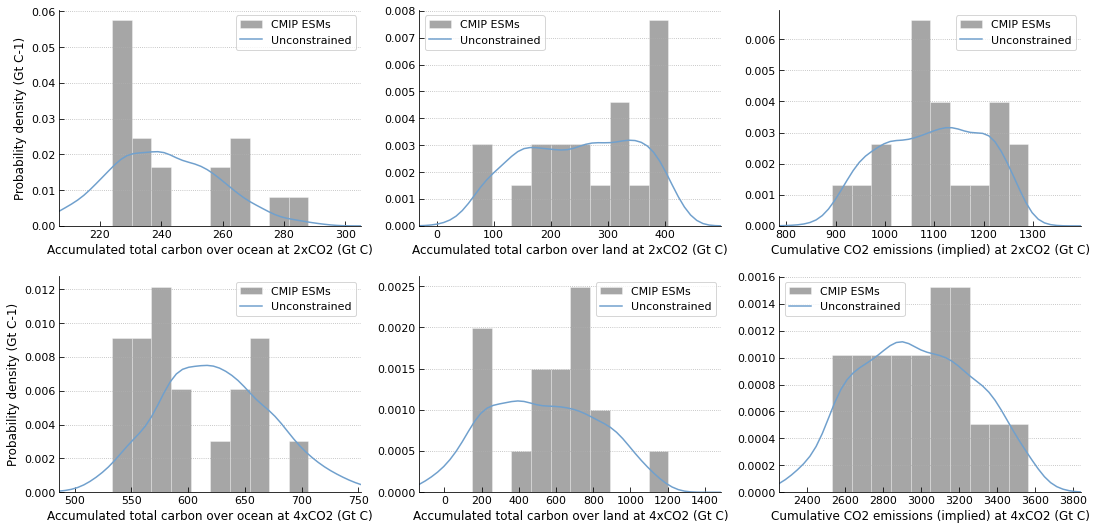

In [52]:
map_label= {
    attrs['variables']['ctot']['long_name']:
    '{} (implied)'.format(
        attrs['variables']['ctot']['long_name']
    )
}

names = [
    'coct|2x', 'cbst|2x', 'ctot|2x',
    'coct|4x', 'cbst|4x', 'ctot|4x',
]
col = 3
myplt.init_regular(len(names), col=col)

for n, name in enumerate(names):
    ax = myplt(n)
    ax.hist(
        df_parms_cmip_esm[name], alpha=0.35, density=True, label='CMIP ESMs',
        edgecolor='w',
    )
    kde = scipy.stats.gaussian_kde(gind[name])
    xlim = ax.get_xlim()
    xlim_ext = (
        xlim[0] - 0.2*(xlim[1]-xlim[0]),
        xlim[1] + 0.2*(xlim[1]-xlim[0]),
    )
    xval = np.linspace(*xlim_ext)
    ax.plot(xval, kde(xval), lw=1.5, label='Unconstrained')
    ax.legend()
    ax.set_xlim(*xlim_ext)

    vn, xc = name.split('|')
    label = attrs['variables'][vn]['long_name']
    label = map_label.get(label, label)
    units = attrs['variables'][vn]['units']
    ax.set_xlabel('{} at {}CO2 ({})'.format(label, xc, units))
    if n%col == 0:
        ax.set_ylabel('Probability density ({}-1)'.format(units))

    ax.grid(axis='y')

## 3. Constraining

Here, CMIP land accumulated carbon in the 70th year is selected as a single constraint,
and a skewed normal is used for the target probability density.

In [53]:
stat_model = StatModel()
name_target = 'cbst|2x'
constraints = {
    'very_likely__lower': df_parms_cmip_esm[name_target].quantile(0.05),
    'central': df_parms_cmip_esm[name_target].mean(),
    # consider mean value as median
    'very_likely__upper': df_parms_cmip_esm[name_target].quantile(0.95),
}
rv = stat_model.get_rv('skewnorm', constraints, a=0., loc=270., scale=50.)
name_target, rv.args, rv.kwds

('cbst|2x',
 (-2.761983351435173,),
 {'loc': 373.3282785545086, 'scale': 155.6295325986082})

In [54]:
# Apply MH sampler
obj_mh = SamplingMH(pd.Series(gind[name_target]), rv.pdf)
index1, index1a = obj_mh.sampling()
print('acceptance rate', len(index1a)/len(index1))

acceptance rate 0.8305


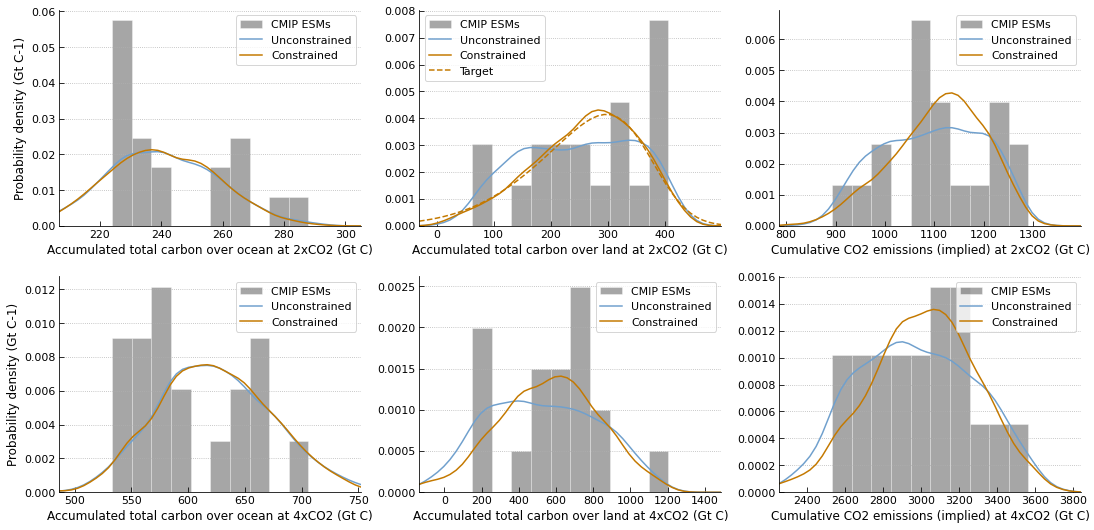

In [55]:
col = 3
myplt.init_regular(len(names), col=col)

for n, name in enumerate(names):
    ax = myplt(n)
    ax.hist(
        df_parms_cmip_esm[name], alpha=0.35, density=True, label='CMIP ESMs',
        edgecolor='w',
    )
    kde = scipy.stats.gaussian_kde(gind[name])
    xlim = ax.get_xlim()
    xlim_ext = (
        xlim[0] - 0.2*(xlim[1]-xlim[0]),
        xlim[1] + 0.2*(xlim[1]-xlim[0]),
    )
    xval = np.linspace(*xlim_ext)
    ax.plot(xval, kde(xval), lw=1.5, label='Unconstrained')

    kde = scipy.stats.gaussian_kde(gind[name][:][index1])
    ax.plot(xval, kde(xval), lw=1.5, label='Constrained')

    if name == name_target:
        ax.plot(
            xval, rv.pdf(xval), lw=1.5, color=ax.lines[-1]._color,
            ls='--', label='Target',
        )

    ax.legend()
    ax.set_xlim(*xlim_ext)

    vn, xc = name.split('|')
    label = attrs['variables'][vn]['long_name']
    label = map_label.get(label, label)
    units = attrs['variables'][vn]['units']
    ax.set_xlabel('{} at {}CO2 ({})'.format(label, xc, units))
    if n%col == 0:
        ax.set_ylabel('Probability density ({}-1)'.format(units))

    ax.grid(axis='y')

In [56]:
# Additional indicators for diagnostics
df = df_parms_cmip_esm

for cx in ['2x', '4x']:
    df[f'coct+cbst|{cx}'] = df[f'coct|{cx}'] + df[f'cbst|{cx}']
    df[f'coct_ratio|{cx}'] = df[f'coct|{cx}'] / df[f'coct+cbst|{cx}']

    d = gind.create_dataset(
        f'coct+cbst|{cx}',
        data=gind[f'coct|{cx}'][:] + gind[f'cbst|{cx}'][:],
    )
    d.attrs['units'] = gind[f'coct|{cx}'].attrs['units']
    
    d = gind.create_dataset(
        f'coct_ratio|{cx}',
        data=gind[f'coct|{cx}'][:] / gind[f'coct+cbst|{cx}'][:],
    )
    d.attrs['units'] = 'none'

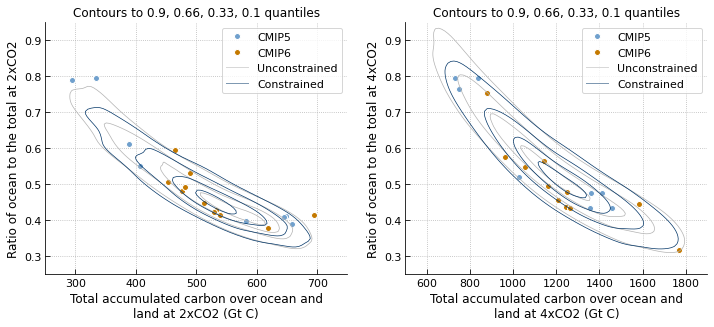

In [57]:
# Characteristic relationships associated with carbon cycle

map_lim = {
    'coct+cbst|2x': (250., 750.),
    'coct+cbst|4x': (500., 1900.),
    'coct_ratio|2x': (0.25, 0.95),
    'coct_ratio|4x': (0.25, 0.95),
}
map_vn = {
    'coct+cbst': 'Total accumulated carbon over ocean and land',
    'coct_ratio': 'Ratio of ocean to the total'
}
map_colors = {
    'cmip5': 'C1',
    'cmip6': 'C2',
}
kw_plot_cmip = {'ls': 'None', 'marker': 'o', 'mec': 'w'}
prob_ref = np.array([0.90, 0.66, 0.33, 0.1])

myplt.init_regular(2, col=2, kw_space={'height': 3.5, 'aspect': 1.2})

for n, (xvar, yvar) in enumerate([
    ('coct+cbst|2x', 'coct_ratio|2x'),
    ('coct+cbst|4x', 'coct_ratio|4x'),
]):
    ax = myplt(n)
    for mip, df in df_parms_cmip_esm.groupby('mip'):
        ax.plot(
            df[xvar].values, df[yvar].values, color=map_colors[mip],
            label=mip.upper(), **kw_plot_cmip,
        )

    handles, labels = ax.get_legend_handles_labels()
    xlim = map_lim[xvar]
    ylim = map_lim[yvar]
    xp, yp = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
    positions = np.vstack([xp.ravel(), yp.ravel()])

    din = np.vstack([gind[xvar], gind[yvar]])
    pdf = scipy.stats.gaussian_kde(din)
    zp = pdf(positions).reshape(xp.shape)
    levels = np.quantile(pdf(din), 1.-prob_ref)
    ax.contour(xp, yp, zp, levels, colors='C3', linewidths=0.7)
    handles.append(mpl.lines.Line2D([], [], color='C3', alpha=0.5))
    labels.append('Unconstrained')

    din = np.vstack([gind[xvar][:][index1], gind[yvar][:][index1]])
    pdf = scipy.stats.gaussian_kde(din)
    zp = pdf(positions).reshape(xp.shape)
    levels = np.quantile(pdf(din), 1.-prob_ref)
    ax.contour(xp, yp, zp, levels, colors='C4', linewidths=0.7)
    handles.append(mpl.lines.Line2D([], [], color='C4', alpha=0.5))
    labels.append('Constrained')

    ax.legend(handles, labels)

    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)

    for name, axis in zip([xvar, yvar], ['x', 'y']):
        vn, cx = name.split('|')
        label = '{} at {}CO2'.format(map_vn[vn], cx)
        units = gind[name].attrs['units']
        if units != 'none':
            label = f'{label} ({units})'

        getattr(ax, 'set_{}label'.format(axis))('\n'.join(textwrap.wrap(label, 40)))

    ax.set_title(
        'Contours to {} quantiles'.format(
            ', '.join([f'{x}' for x in prob_ref])
        ),
    )
    ax.grid()

In [58]:
ds.close()

[2025-04-30 15:49:20 mce.core] INFO:file data/ds_ens_cmip5and6.h5 closed
